In [1]:
!pip install SciencePlots

In [2]:
import numpy as np
from utils.data_loader import DataLoader
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
import scienceplots
import time
from joblib import delayed, Parallel
from concurrent.futures import ProcessPoolExecutor

plt.style.use(['science','no-latex', 'ieee'])
plt.rcParams.update({
    "font.family": "DejaVu Sans",   # specify font family here
})

In [3]:
def linear_map(signal):
    if not type(signal) is np.ndarray:
        signal = np.array(signal)
    a, b = max(signal), min(signal)
    return (2*signal-(a+b))/(a - b)

# def binarize_lm(signal):
#     if not type(signal) is np.ndarray:
#         signal = np.array(signal)
#     a, b = max(signal), min(signal)
#     signal_lm = linear_map(signal)
#     signal_bin = np.ones_like(signal_lm)
#     signal_bin[signal_lm > 0] = 1
#     signal_bin[signal_lm < 0] = -1
#     return signal_bin

def binarize_lm(signal):
    signal = np.array(signal)
    arr_sorted = np.sort(signal)
    avg_max = np.mean(arr_sorted[-10:])
    avg_min = np.mean(arr_sorted[:10])
    cutoff = (avg_max + avg_min)/2
#     print(avg_max, avg_min, cutoff)
    bin_signal = np.zeros_like(signal)
    bin_signal[signal > cutoff] = 1
    return bin_signal

In [4]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)
dloader = DataLoader(root_dir)
sk = np.load('skull_indices_flat.npy')

In [5]:
dloader.diag.index(1)

9

In [7]:
ad_freq, ad_psd = get_power_spectrum(9)
cn_freq, cn_psd = get_power_spectrum(10)
ad_mean = np.mean(ad_psd, axis=0)
ad_std = np.std(ad_psd, axis=0)
cn_mean = np.mean(cn_psd, axis=0)
cn_std = np.std(cn_psd, axis=0)
# plot the mean with shaded error bars
plt.plot(ad_freq, ad_mean, label='AD')
plt.fill_between(ad_freq, ad_mean - ad_std, ad_mean + ad_std, alpha=0.2)
plt.plot(cn_freq, cn_mean, label='CN')
plt.fill_between(cn_freq, cn_mean - cn_std, cn_mean + cn_std, alpha=0.2)
plt.plot(cn_freq, 1/cn_freq, label='1/f')
plt.xlabel('f (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()


NameError: name 'get_power_spectrum' is not defined

In [6]:
sk_idx = np.load('skull_indices.npy')
sk_x = slice(min(sk_idx[0]), max(sk_idx[0])+1)
sk_y = slice(min(sk_idx[1]), max(sk_idx[1])+1)
sk_z = slice(min(sk_idx[2]), max(sk_idx[2])+1)

In [7]:
ad_fdata = dloader.get_func(31).get_fdata()
cn_fdata = dloader.get_func(40).get_fdata()
ad_grid = ad_fdata[sk_x, sk_y, sk_z]
cn_grid = cn_fdata[sk_x, sk_y, sk_z]
ad_yz_img = ad_grid[10]
cn_yz_img = cn_grid[10]
ad_img = np.apply_along_axis(binarize_lm, 3, ad_grid)
cn_img = np.apply_along_axis(binarize_lm, 3, cn_grid)


In [8]:
x_len, y_len, z_len = ad_img.shape[:-1]
i_tuples = [(x, y, z)  for x in range(x_len) for y in range(y_len) for z in range(z_len) if (x, y, z) in sk_idx.T]

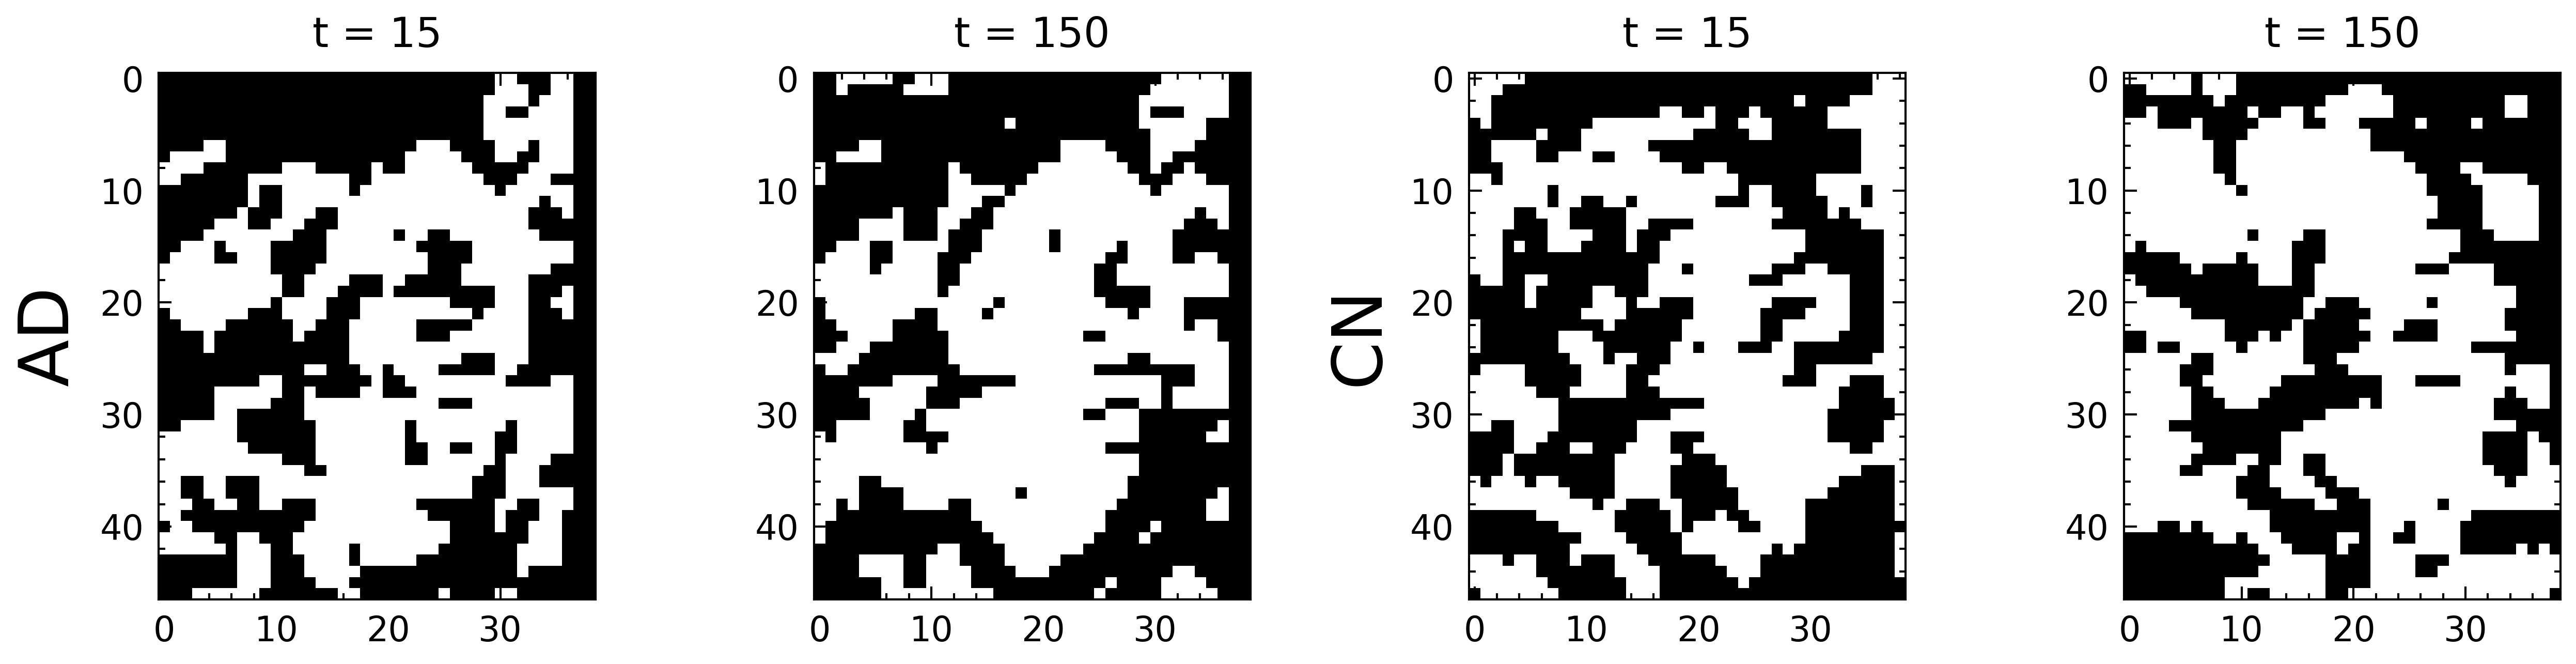

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
t= [5, 50]
# plot the first row of images
cmap = plt.cm.binary_r  # reverse binary colormap (black = 1, white = 0)
cmap.set_over('w')  # set 1's to white
cmap.set_under('k')  # set -1's to black
for i in range(2):
    ax[i].imshow(ad_img[10, :, :, t[i]], cmap=cmap)
    ax[i].set_title('t = {}'.format(t[i]*3))
ax[ 0].set_ylabel('AD', fontsize=16)

# plot the second row of images
for i in range(2):
    ax[2+i].imshow(cn_img[10, :, :, t[i]],cmap=cmap)
    ax[2+i].set_title('t = {}'.format(t[i]*3))
    
ax[2].set_ylabel('CN', fontsize=16)
plt.subplots_adjust(wspace=0.5) 
# add a title for the entire plot
# show the plot
plt.savefig('results/plots/domains.svg')

In [ ]:
import csv

x_len, y_len, z_len = ad_img.shape[:-1]
i_tuples = [(x, y, z) for x in range(x_len) for y in range(y_len) for z in range(z_len)]
ts = [5, 20, 50, 80, 100, 130]
for t in ts:
    print(t)
    with open(f"results/bin_lattice/CN_{t}.csv", "w", newline="") as f:
        rows = []
        for i in i_tuples:
            row = list(i)
            row.append(cn_img[i][t])
            row_str = ' '.join(str(num) for num in row)
            f.write(row_str+'\n')


In [56]:
ad_sc = np.load('results/ad_sc_5.npy')
ad_npoints = np.load('results/ad_sc_n_points_5.npy')
cn_sc = np.load('results/cn_sc_5.npy')
cn_npoints = np.load('results/cn_sc_n_points_5.npy')

In [58]:
ad_sc_norm = ad_sc[1:]/ad_npoints[1:]
cn_sc_norm = cn_sc[1:]/cn_npoints[1:]

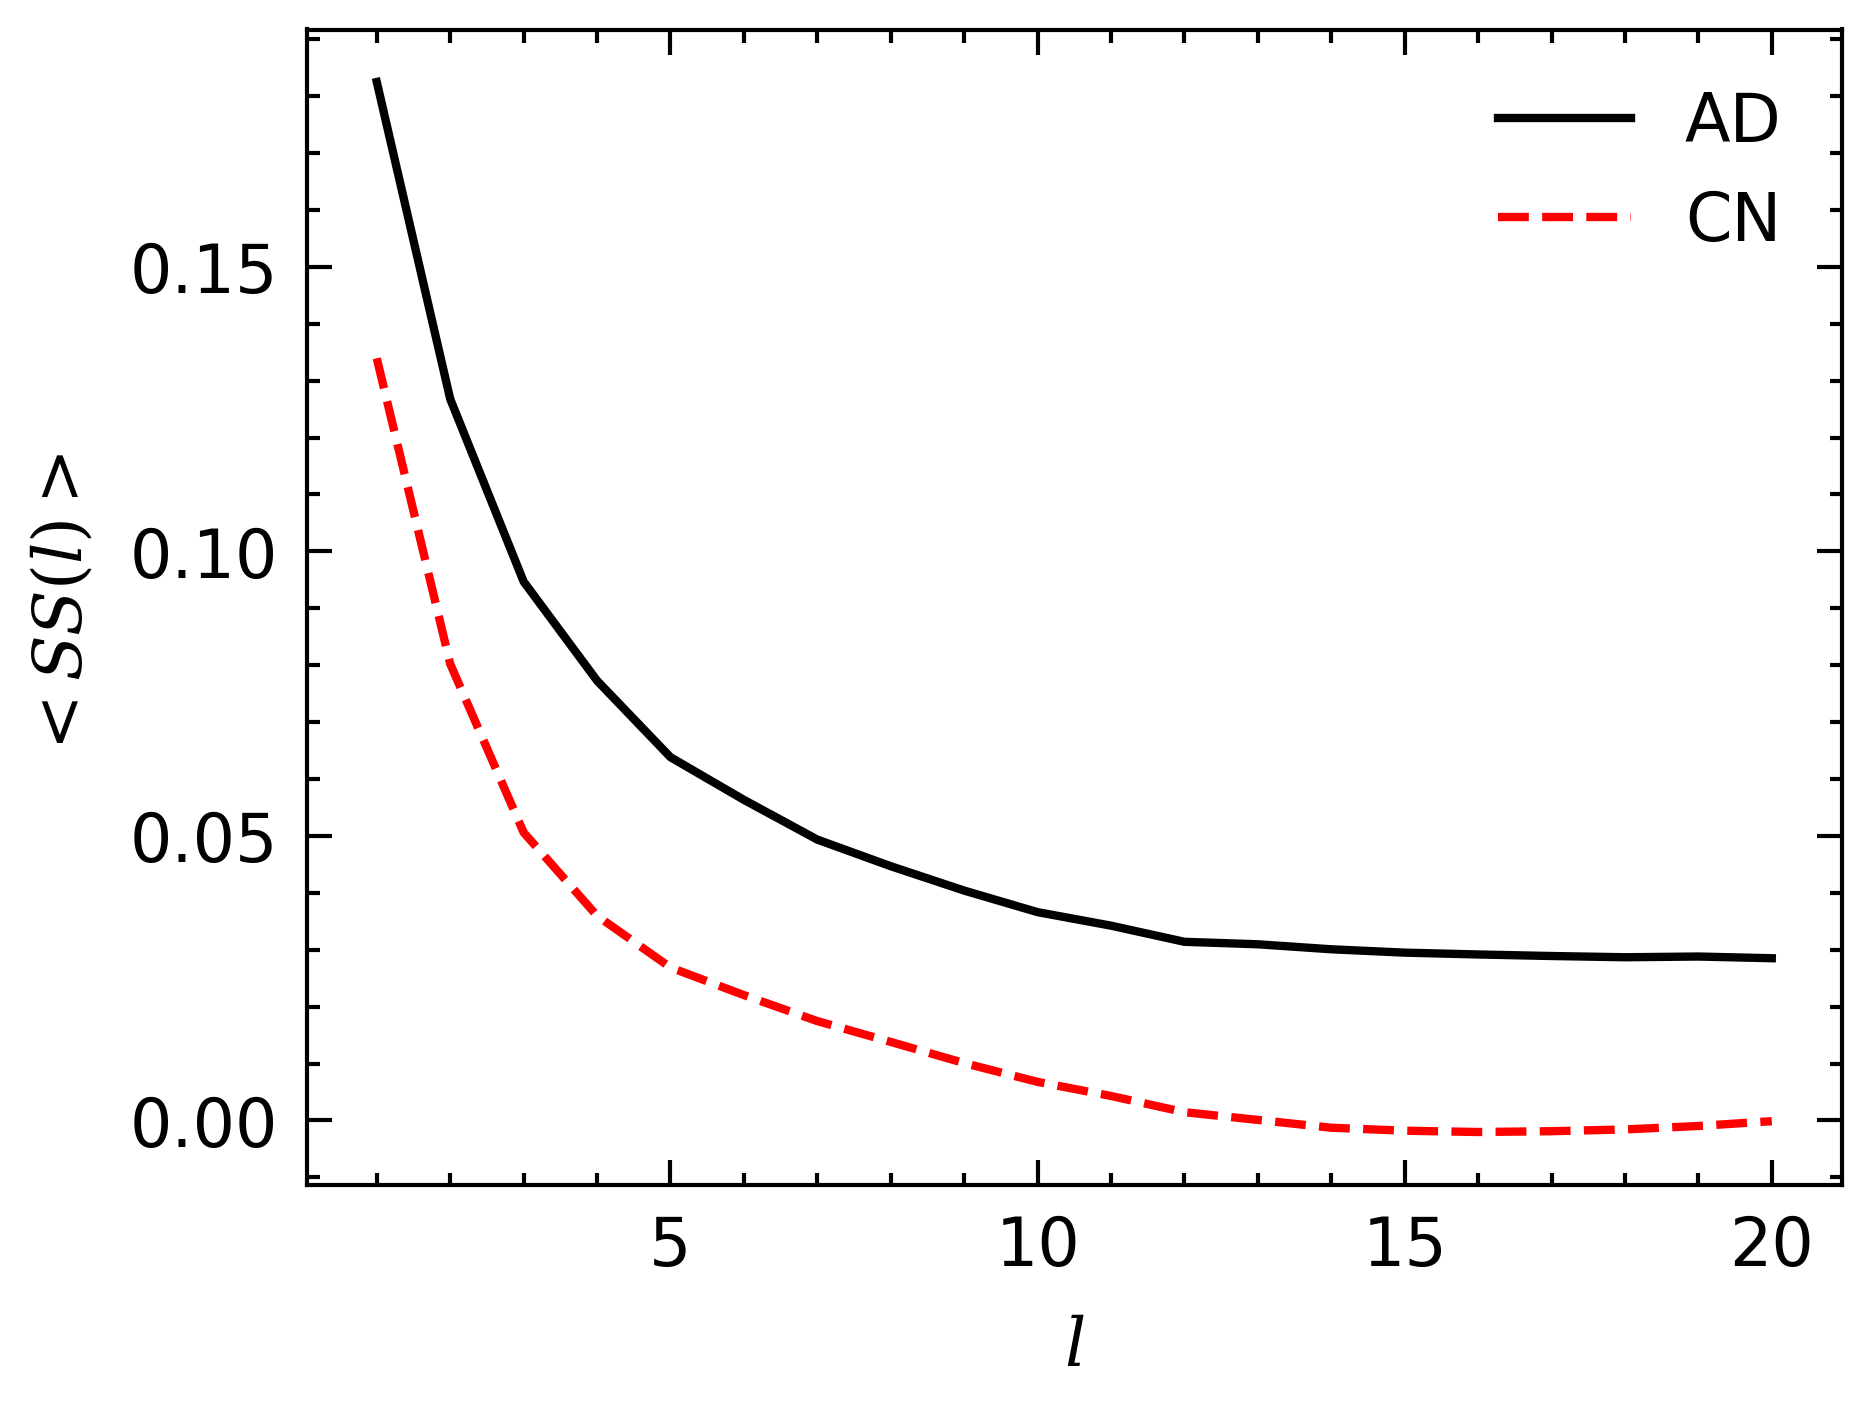

In [63]:
plt.plot(range(1, len(cn_sc_norm)+1), ad_sc_norm[:20], label='AD')
plt.plot(range(1, len(cn_sc_norm)+1), cn_sc_norm, label='CN')
plt.xlabel('$l$')
plt.ylabel('$<SS(l)>$')
plt.legend()
plt.show()

In [7]:
from scipy.optimize import curve_fit

def exp_decay(t, tau, A, B=0):
    return A * np.exp(-t/tau) + B

def st_exp_decay(t, tau, A, beta, B=0):
    return A * np.exp(-np.power(t/tau, beta)) + B

def get_exp_fit(x, t_max=None):
        t = list(range(len(x)))                                            
        if t_max is None:
            t_max = len(t)-1
        B = np.mean(x[3*t_max//4:])
        p0 = [t[t_max], x[0] - B, B]
        bounds = [[0, 0, -0.1], [np.inf, np.inf, np.inf]]
#         A = 1 - B
#         func = lambda t, tau: exp_decay(t, tau, A=A, B=B)
        popt, pcov = curve_fit(exp_decay, t[:t_max], x[:t_max], p0=p0, bounds=bounds)
        se = np.sqrt(np.mean(np.diag(pcov)))
        t = np.array(t)
        res = x - exp_decay(t, *popt)
        rmse = np.sqrt(np.mean(res**2))
        tau = popt[0]
        A = popt[1]
        B = popt[2]
        return tau, A, B, rmse, se

In [18]:
ad = [81, 70, 43, 40, 14]
cn = [59, 61, 33, 28, 2]
T = [5, 10, 30, 60]
L = range(0, 21)

In [19]:
ad_xis = []
ad_sc_res = []
for sub in ad:
    sc_res = np.load(f"results/ad_sc_{sub}.npy") # shape [n_T, 2(norm, n_points), L]
    ad_sc_res.append(sc_res)
    ad_xi = []
    for i in range(sc_res.shape[0]):
        sc_t = sc_res[i][0]
        xi, A, B, rmse, _ = get_exp_fit(sc_t)
        ad_xi.append([xi, A, B, rmse])
    ad_xis.append(ad_xi)
ad_xis = np.array(ad_xis) # [n_subs, n_t, 4]
ad_sc_res = np.array(ad_sc_res)

In [20]:
cn_xis = []
for sub in cn:
    sc_res = np.load(f"results/cn_sc_{sub}.npy") # shape [n_T, 2(norm, n_points), L]
    cn_xi = []
    for i in range(sc_res.shape[0]):
        sc_t = sc_res[i][0]
        xi, A, B, rmse, _ = get_exp_fit(sc_t)
        cn_xi.append([xi, A, B, rmse])
    cn_xis.append(cn_xi)
cn_xis = np.array(cn_xis) # [n_subs, n_t, 4]

Text(0.5, 0, '$l$')

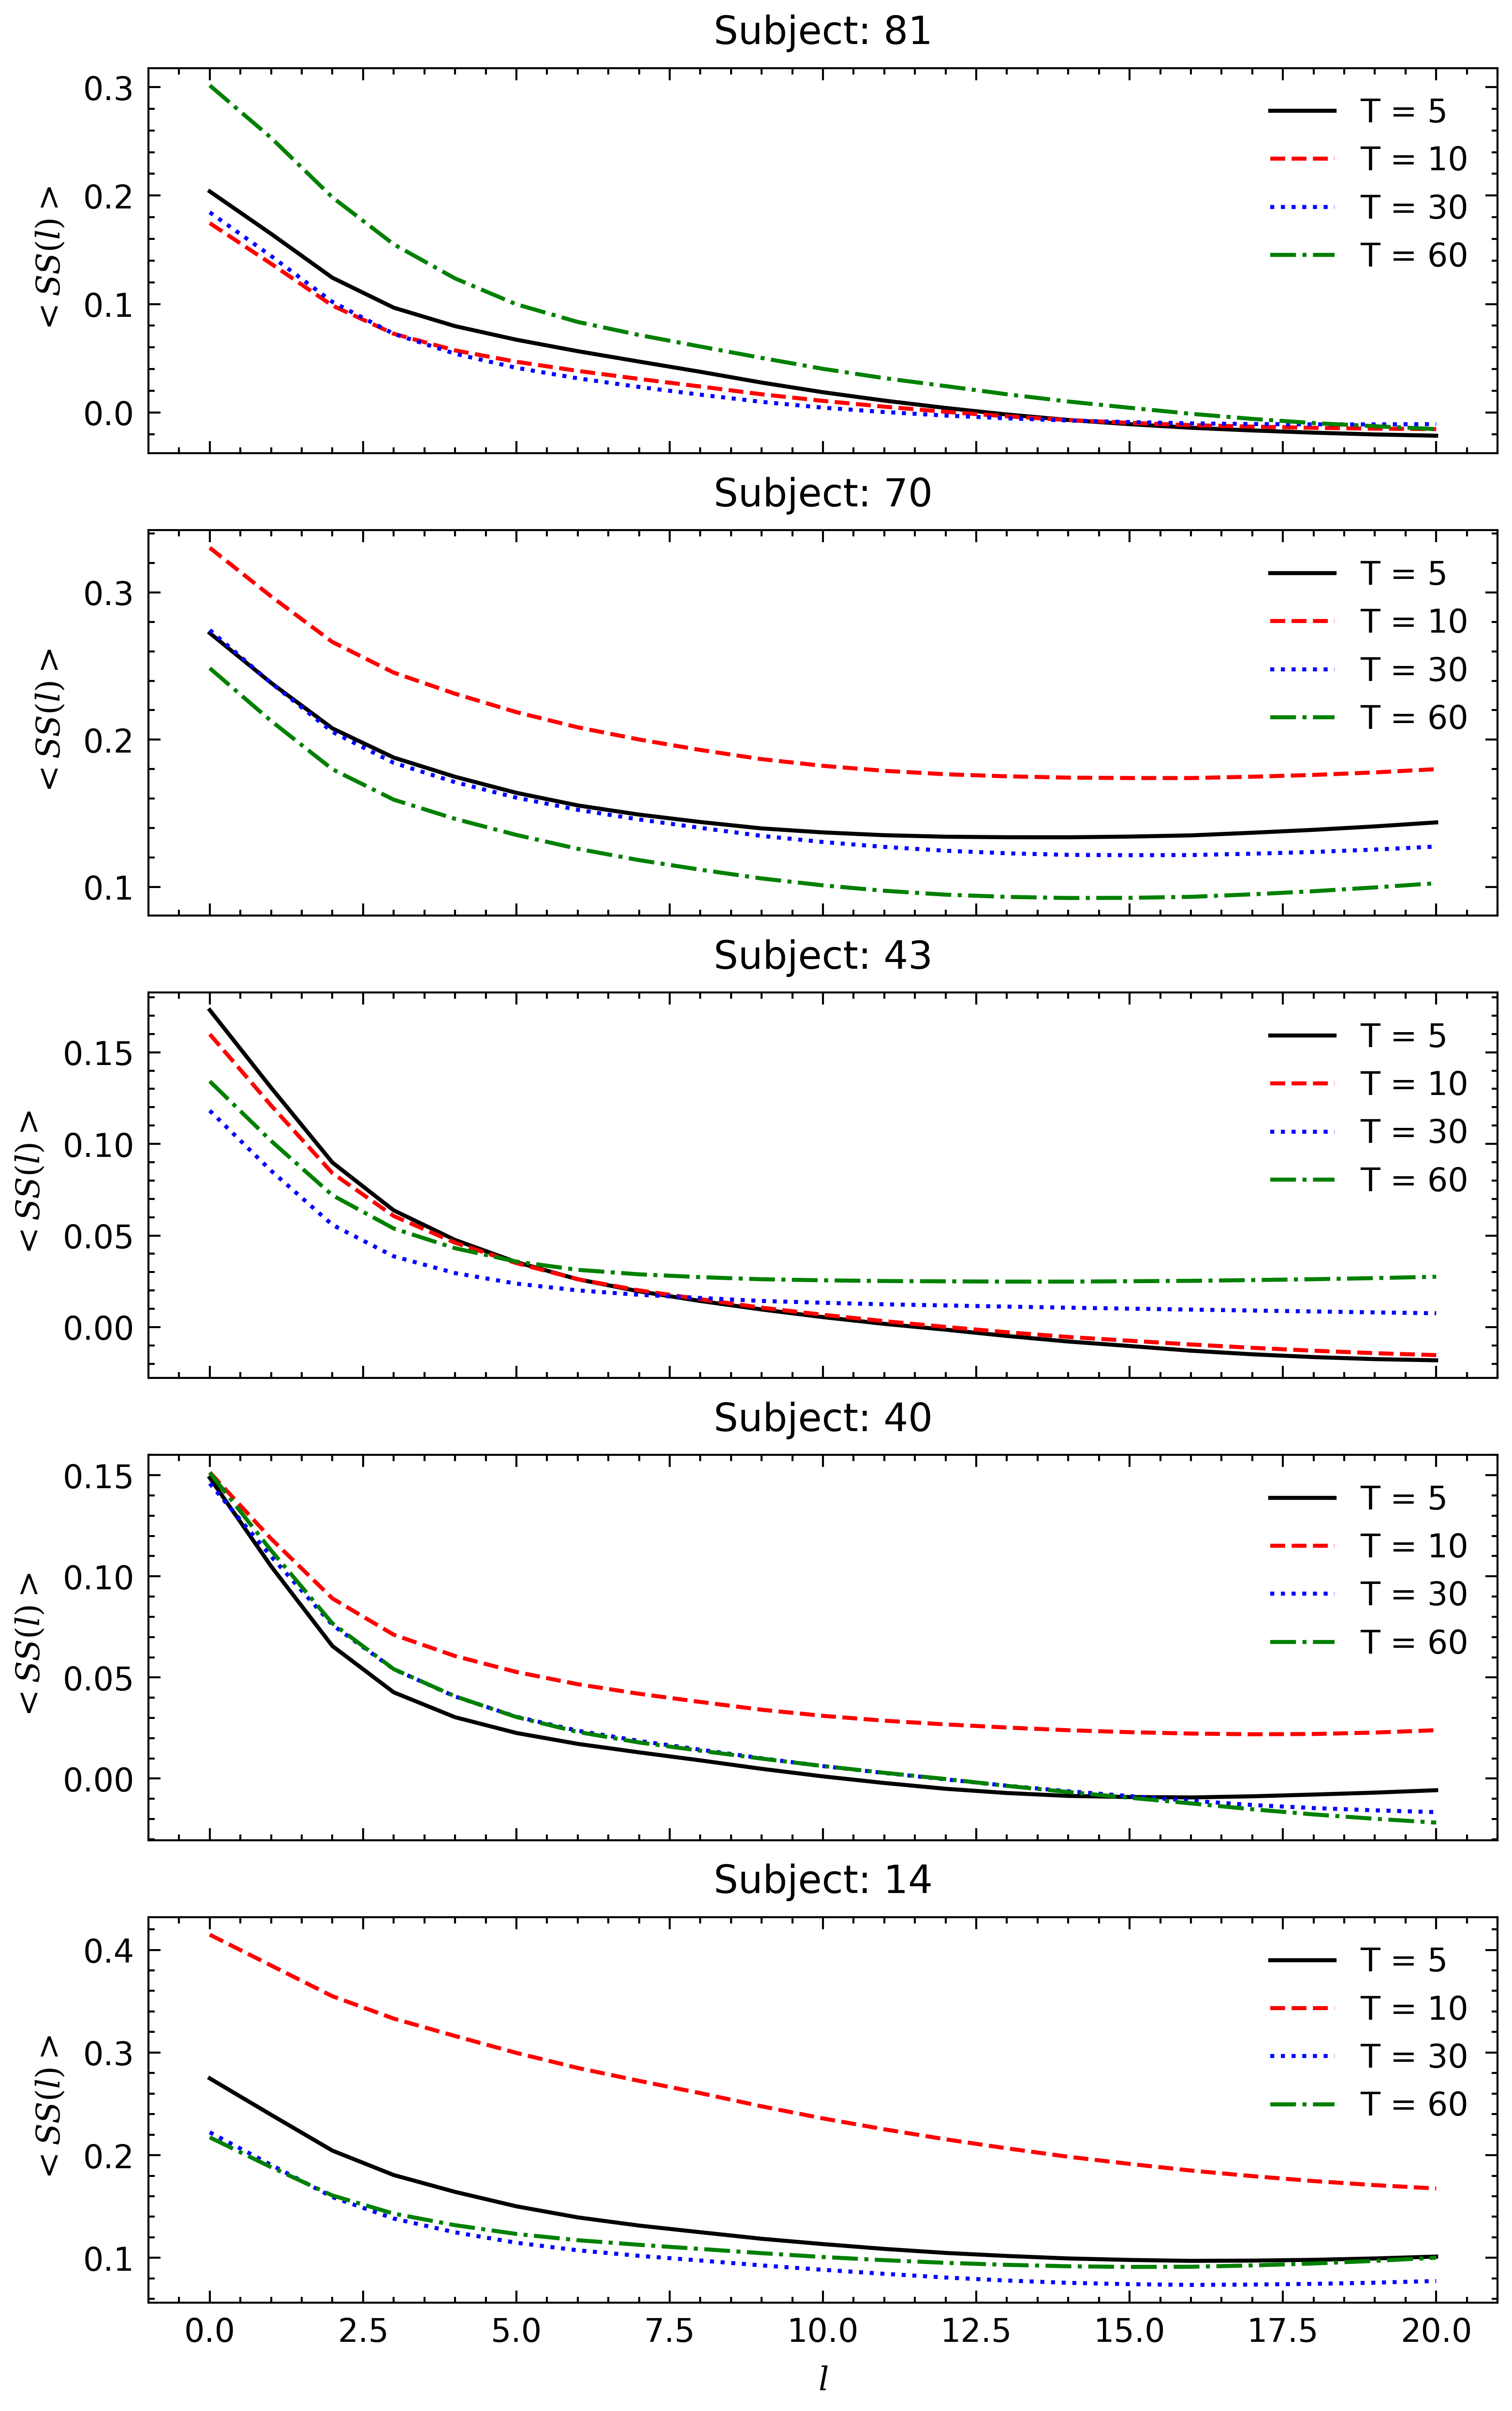

In [32]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(6, 10))
for sub in range(5):
    for t in range(ad_sc_res[sub].shape[0]):
        axs[sub].plot(L, ad_sc_res[sub, t, 0, :], label=f"T = {T[t]}")
    axs[sub].set_ylabel('$<SS(l)>$')
    axs[sub].set_title(f'Subject: {ad[sub]}')
    axs[sub].legend()
axs[sub].set_xlabel('$l$')


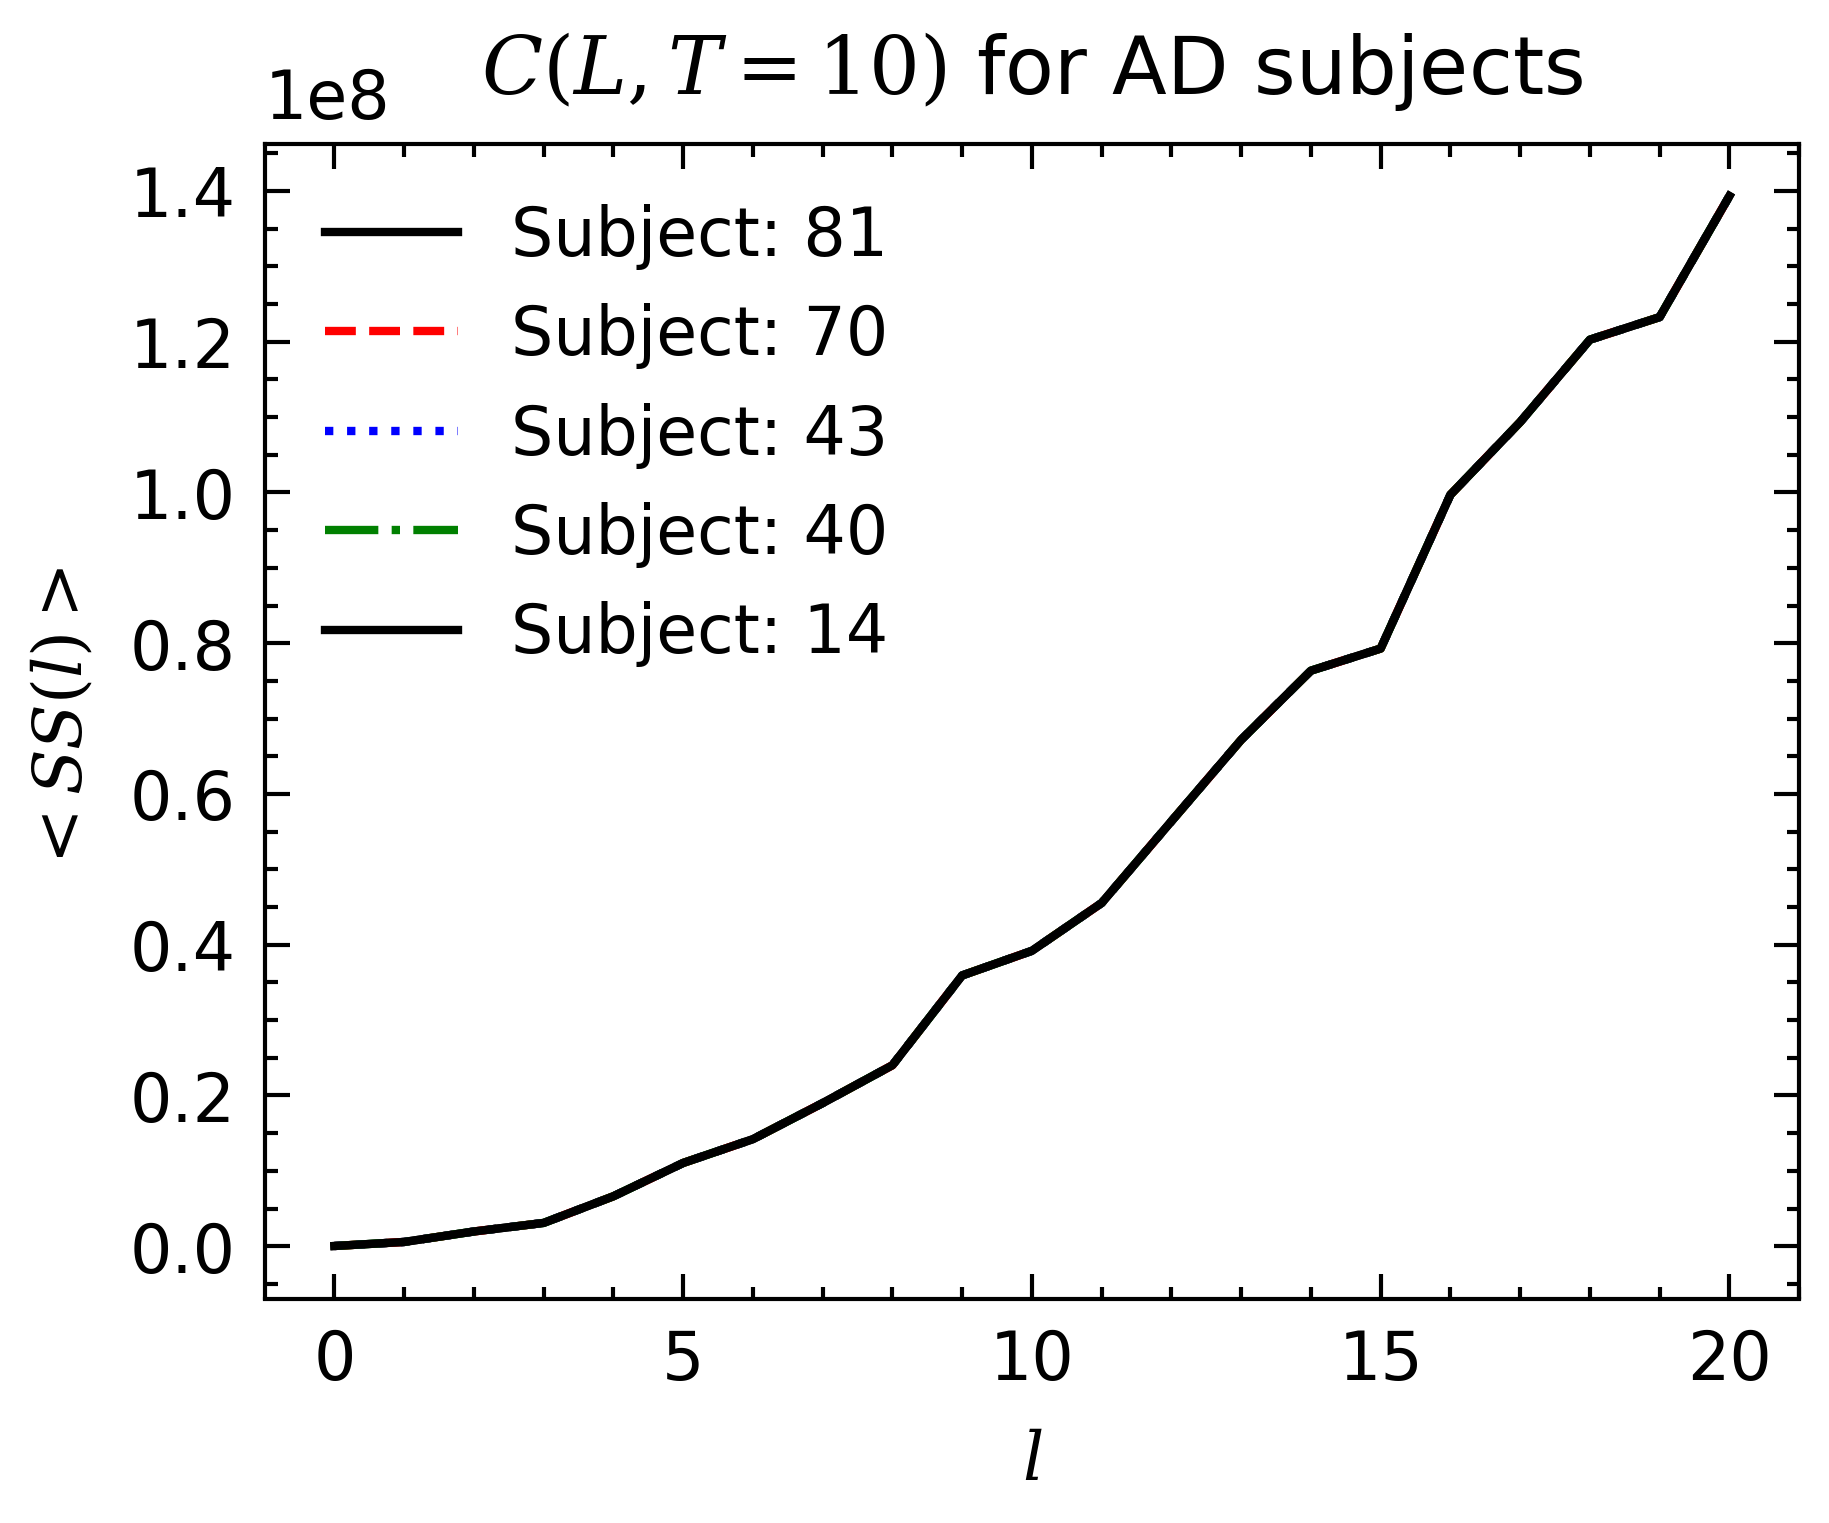

In [37]:
t_i = 1
for sub in range(ad_sc_res.shape[0]):
    plt.plot(L, ad_sc_res[sub, t_i, 0, :], label=f"Subject: {ad[sub]}")
plt.xlabel('$l$')
plt.ylabel('$<SS(l)>$')
plt.title('$C(L, T=10)$ for AD subjects')
plt.legend()

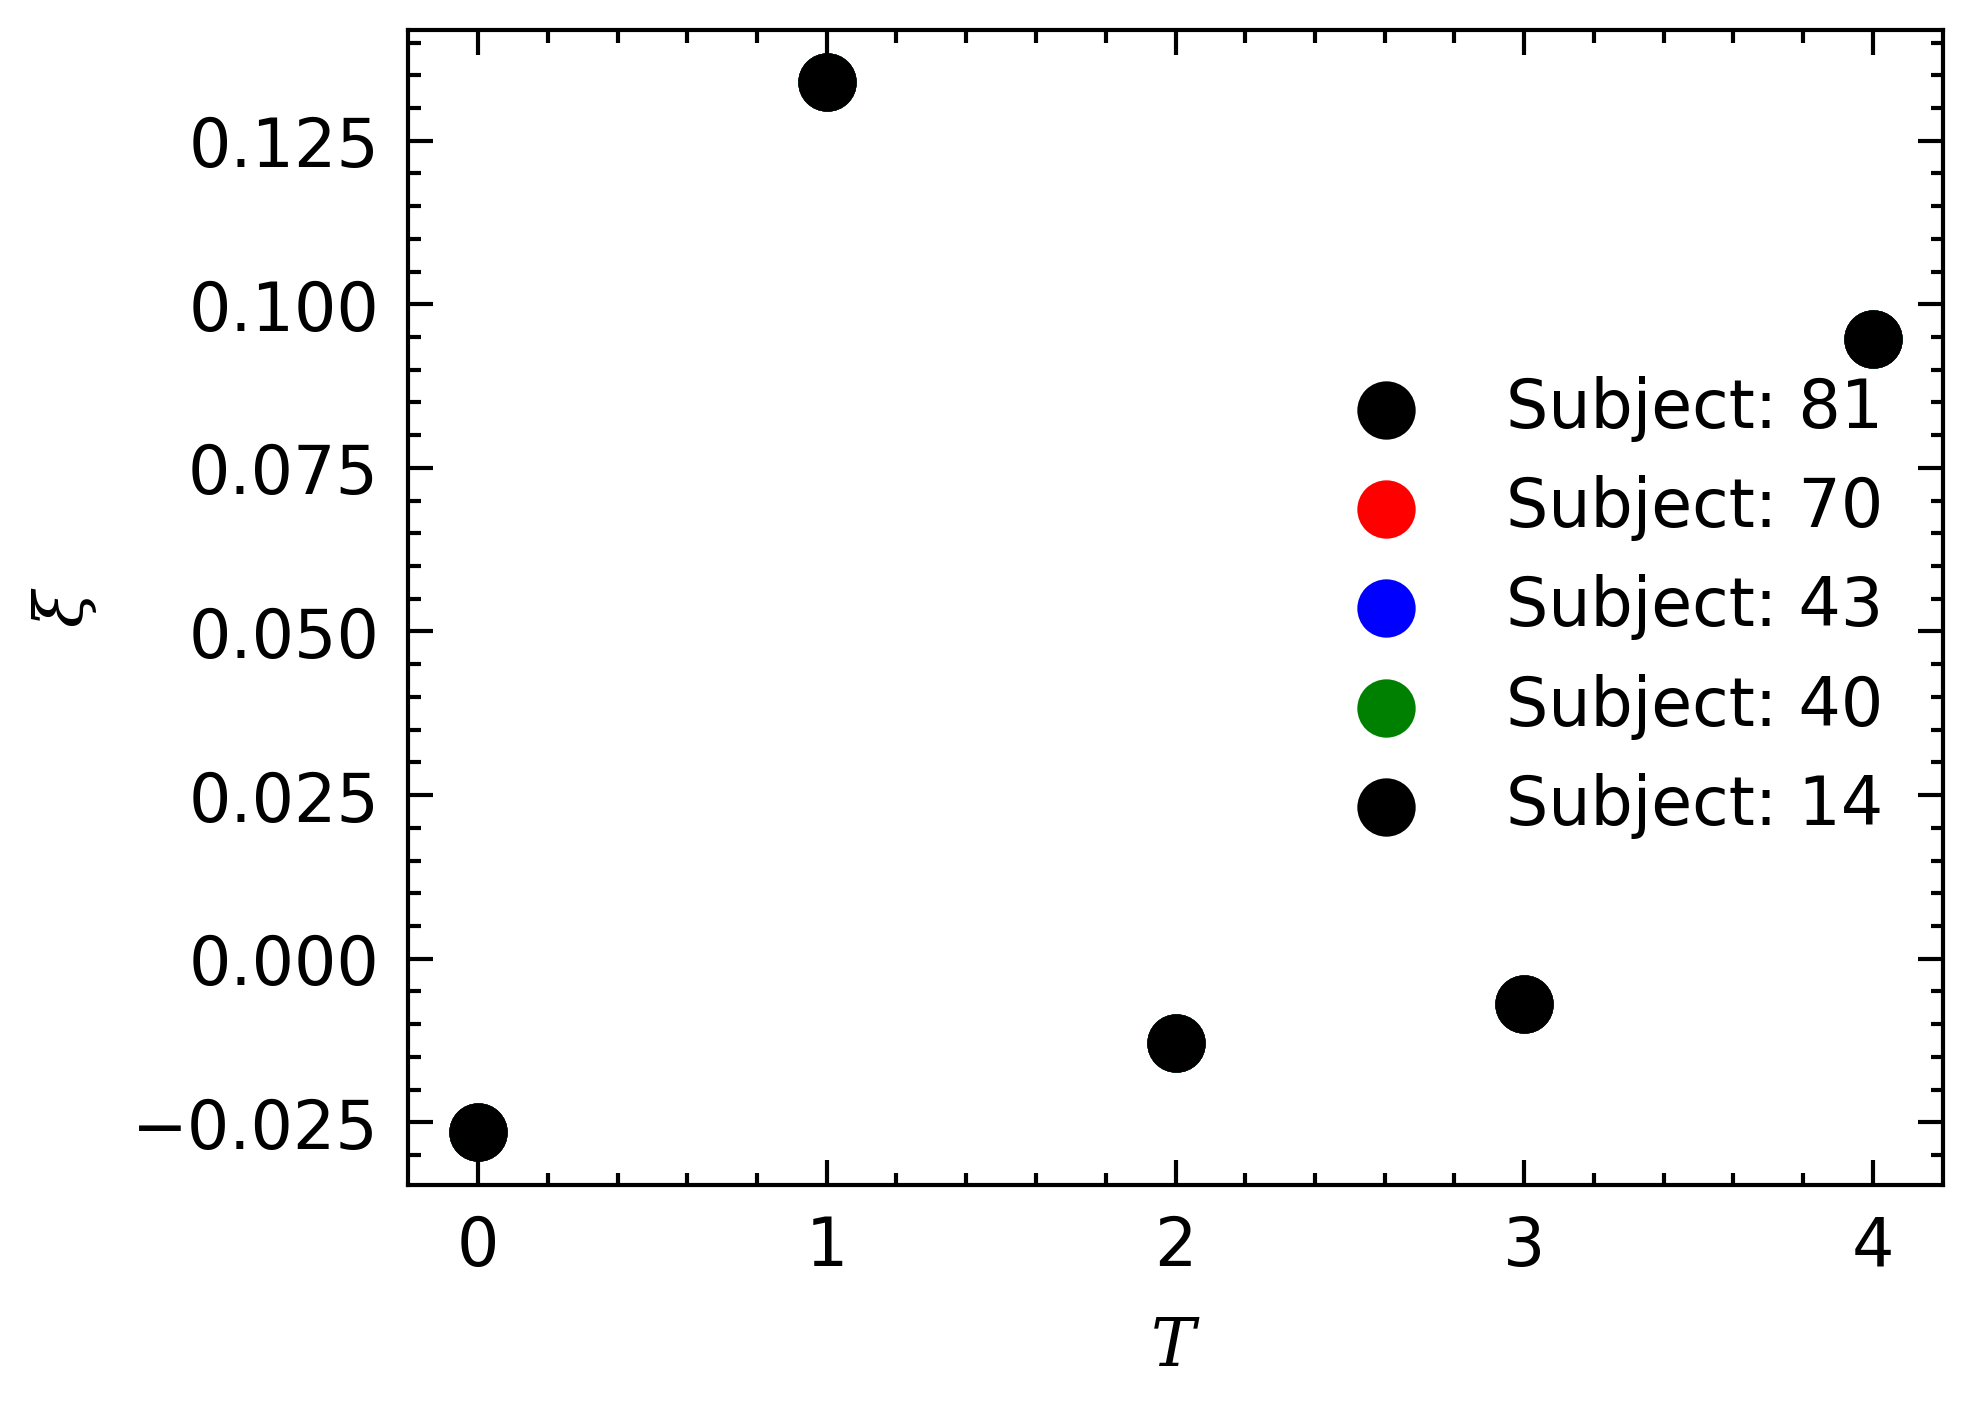

In [39]:
for sub in range(ad_xis.shape[0]):
# for sub in range(1):
plt.scatter( range(ad_xis.shape[0]), ad_xis[:, 0, 2], label=f"Subject: {ad[sub]}")
    # plt.plot(T, cn_xis[:, 0], label="CN")
plt.xlabel('$T$')
# plt.ylabel('$\\xi$')
plt.legend()
plt.show()

In [ ]:
for sub in range(ad_xis.shape[0]):
# for sub in range(1):
    plt.scatter(T, ad_xis[sub, :, 2], label=f"Subject: {ad[sub]}")
    # plt.plot(T, cn_xis[:, 0], label="CN")
plt.xlabel('$T$')
plt.ylabel('$\\xi$')
plt.legend()
plt.show()